## 混合モデルとEM

- K-means クラスタリング
- 混合ガウス分布
- EMアルゴリズムのもう一つの解釈

の3つについて，解説されている．

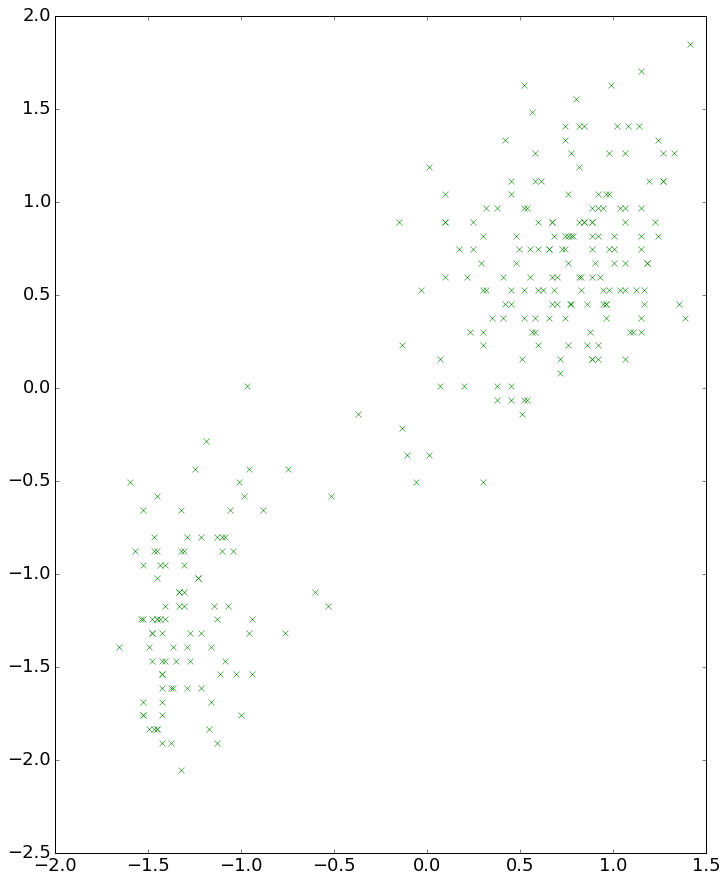

In [33]:
# refer : http://aidiary.hatenablog.com/entry/20100521/1274445325
import numpy as np
import matplotlib.pyplot as plt

def scale(X):
    """平均0，分散1に正規化する関数"""
    col = X.shape[1]
    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    for i in range(col):
        X[:, i] = (X[:, i] - mu[i]) / sigma[i]
    return X

# official faithful url is expaired, so use third party
faithful_url = "https://raw.githubusercontent.com/aidiary/PRML/master/ch9/faithful.txt"
data = np.genfromtxt(faithful_url)
X = scale(data[:, 0:2])
N = len(X)

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams["font.size"] = 18
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(X[:,0], X[:,1], 'gx')
plt.show()

上のようなデータがあったときに，K-meansでクラスタリングする方法が考えられる．
しかし，K-meansだと確率的ではなくて，0 or 1で明確にクラスタリングされている（ハード割り当て）ことになっており，微妙．
ソフト割り当ての方がよさ気な気はする．その方法の一つとして，ガウス混合分布が考えられる．
与えられたデータをガウス混合分布に割り当てるときには，EM法が使える．

singleのガウス分布だと，
$$
\begin{align}
\mu_{ML} &= \frac{1}{N}\sum_{n=1}^N x_n \\
\sigma^2_{ML} &= \frac{1}{N-1}\sum_{n=1}^N (x_n-\mu_{ML})^2
\end{align}
$$
のようにデータからそのまま求まるが，混合ガウス分布だと
$$
\begin{align}
\mu_k &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) x_n\\
\Sigma_k &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk})(x_n - \mu_k)(x_n - \mu_k)^T\\
\pi_k &= \frac{N_k}{N}\\
N_k &= \sum_{n=1}^N \gamma(z_{nk})\\
\gamma(z_{nk}) &= p(z_k = 1|x_n) = \frac{\pi_k N(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j N(x_n|\mu_j, \Sigma_j)}
\end{align}
$$
となるから，負担率$\gamma(z_{nk})$を求める方向と負担率を使う方向の2方向を繰り返す必要がある．

初期値となる$\mu_k$，$\Sigma_k$，$\pi_k$を適当に決めて，
- Eステップ：与えられた$\mu_k$，$\Sigma_k$，$\pi_k$を使って，負担率を計算する
- Mステップ：求めた負担率を使って，$\mu_k$，$\Sigma_k$，$\pi_k$を計算する

のループを収束するまで繰り返す．
収束判定は対数尤度関数が変化しなくなったら．

ちなみに，
$$
p(z_k = 1) = \pi_k\\
p(x|z_k = 1) = N(x|\mu_k, \Sigma_k)
$$
なので，混合ガウス分布は
$$
p(x) = \sum_{z} p(x, z) = \sum_{z} p(z) p(x|z) = \sum_{k=1}^K \pi_k N(x|\mu_k, \Sigma_k)
$$
となり，サンプル$\left\{x_1, x_2, \cdots, x_N\right\}$が与えられた時に，それらの同時確率は
$$
p(X) = p(x_1)p(x_2) \cdots p(x_N) = \Pi_{n=1}^{N} \sum_{k=1}^K \pi_k N(x_n|\mu_k, \Sigma_k)
$$
だから，対数尤度関数は
$$
\ln p(X|\pi,\mu,\Sigma) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \pi_k N(x_n|\mu_k, \Sigma_k) \right\}
$$
となる．
これを微分して=0を解くと，上の$\mu_k$，$\Sigma_k$，$\pi_k$が出てくる．

### K-meansでクラスタリング
K = 2とする

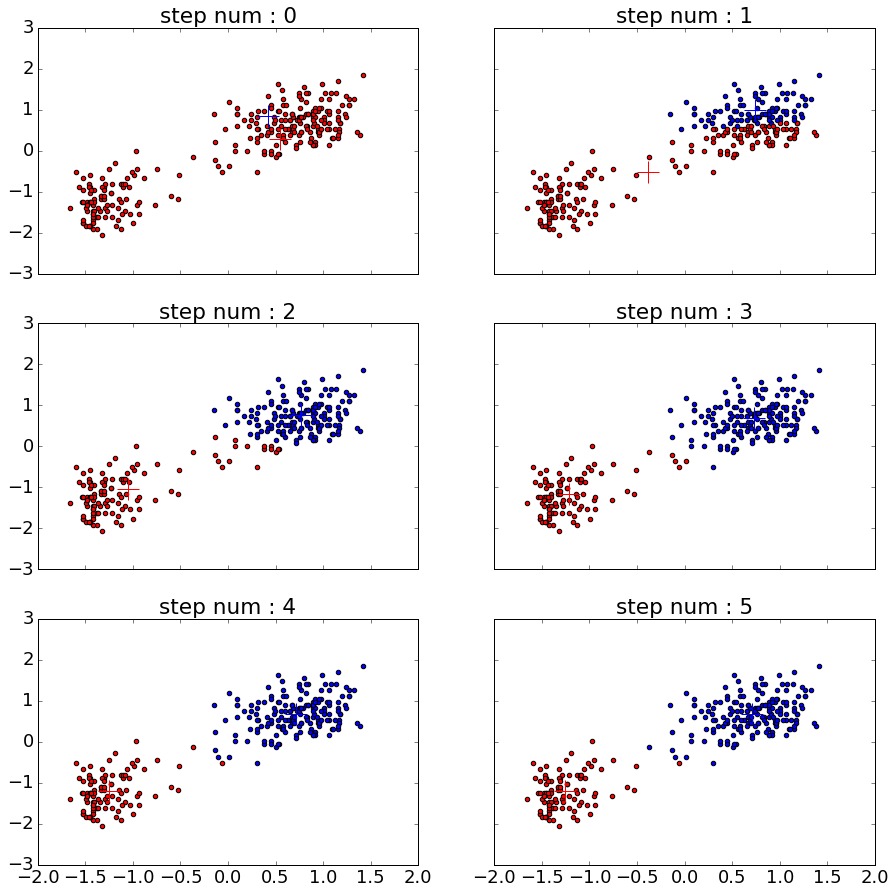

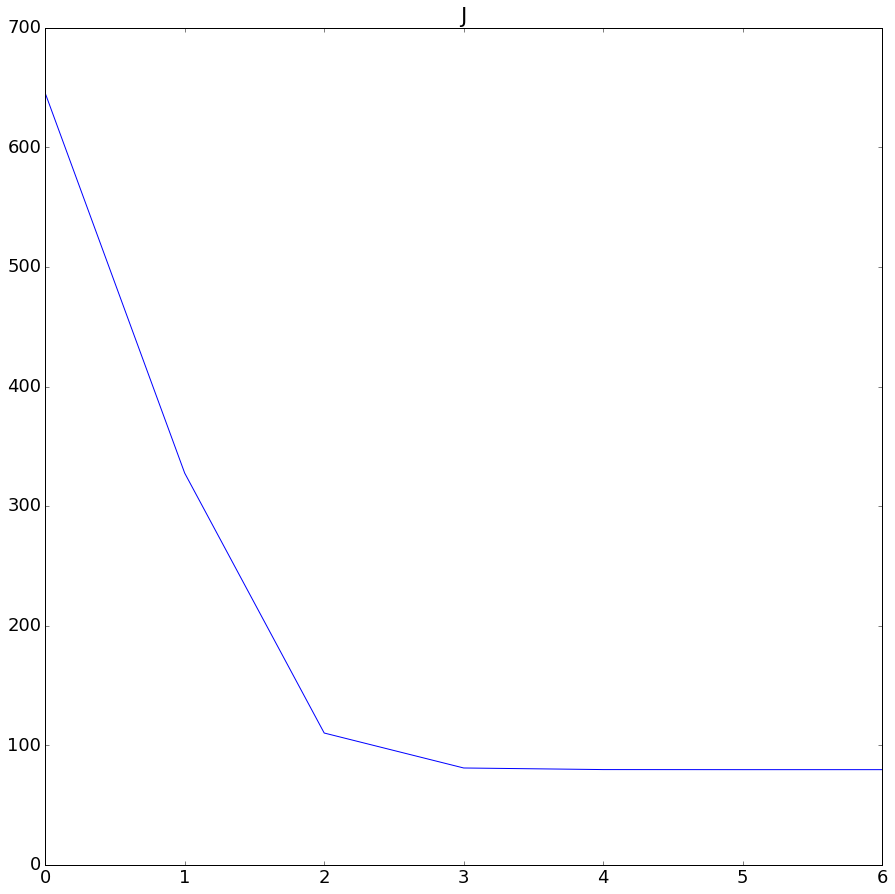

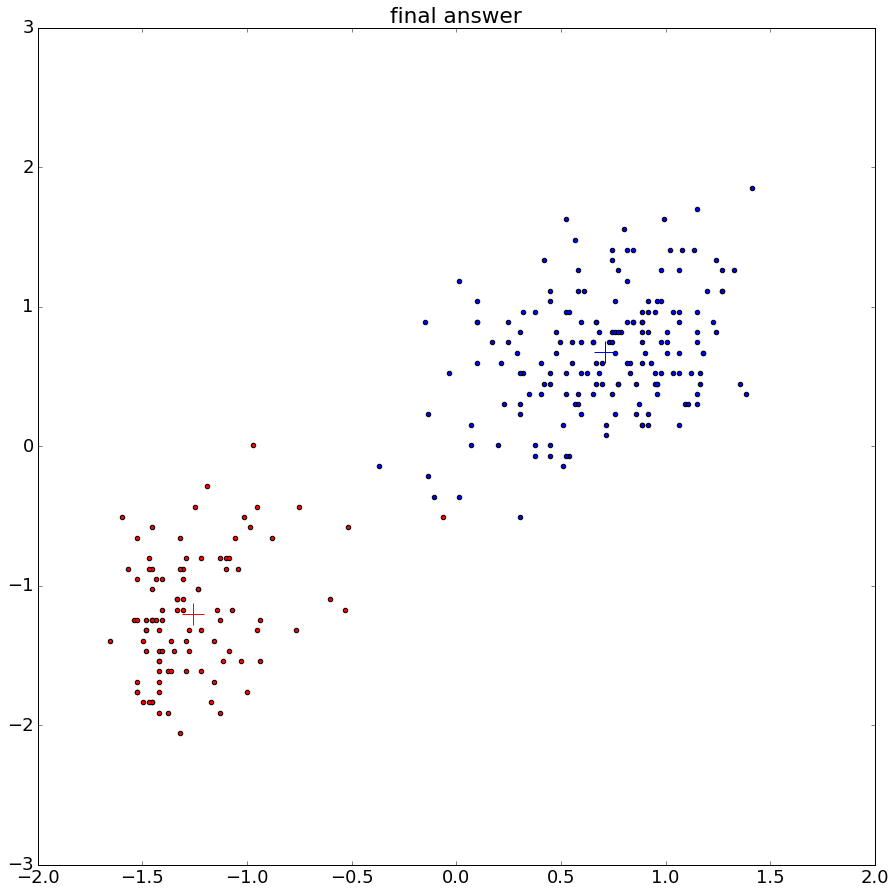

In [34]:
# http://aidiary.hatenablog.com/entry/20100515/1273888686
import copy
K = 2

def J(X, mean, r):
    """式 9.1"""
    sum = 0.0
    for n in range(len(X)):
        inner_sum = 0.0
        for k in range(K):
            inner_sum += r[n, k] * np.linalg.norm(X[n] - mean[k])**2
        sum += inner_sum
    return sum

N = len(X)
# 平均の初期値
np.random.seed(100)
mean = np.random.rand(K, np.shape(X)[1])
# クラス割り当て変数の初期値
r = np.zeros((N, K))
r[:, 0] = 1
# 目的関数の初期値
target = J(X, mean, r)

target_list = [copy.copy(target)]
mean_list = [copy.copy(mean)]
r_list = [copy.copy(r)]
while True:
    # E-step : 現在のパラメータmeanを使って，クラス割り当て変数rを計算 式(9.2)
    for n in range(N):
        idx = -1
        norm_list = [np.linalg.norm(X[n] - mean[k])**2 for k in range(K)]
        idx = np.argmin(norm_list)
        one_of_K = np.zeros(K)
        one_of_K[idx] = 1
        r[n, :] = one_of_K
    
    # M-step : 現在のクラス割当変数rを使って，パラメータmeanを更新 式(9.4)
    for k in range(K):
        numerator = sum([r[n, k] * X[n] for n in range(N)])
        denominator = sum([r[n, k] for n in range(N)])
        mean[k] = numerator / denominator

    # 収束判定
    new_target = J(X, mean, r)
    diff = target - new_target
    if diff < 0.01:
        break
    else:
        target = new_target
        target_list.append(copy.copy(target))
        mean_list.append(copy.copy(mean))
        r_list.append(copy.copy(r))


f, (axes) = plt.subplots(3, 2, sharex=True, sharey=True)
for i in range(6):
    for n in range(N):
        color = ['r', 'b'][np.argmax(r_list[i][n, :])]
        axes[i/2][i%2].scatter(X[n,0], X[n,1], c=color, marker='o')
    for k in range(K):
        axes[i/2][i%2].scatter(mean_list[i][k, 0], mean_list[i][k, 1], s=500, c=['r', 'b'][k], marker='+')
    axes[i/2][i%2].set_title("step num : {}".format(i))
plt.show()

plt.plot(range(len(target_list)+1), target_list + [target])
plt.title("J")
plt.show()

# 描画
for n in range(N):
    color = ['r', 'b'][np.argmax(r[n, :])]
    plt.scatter(X[n,0], X[n,1], c=color, marker='o')
for k in range(K):
    plt.scatter(mean[k, 0], mean[k, 1], s=500, c=['r', 'b'][k], marker='+')
plt.title("final answer")
plt.show()

これがk-meansによるクラスタリング．

境界値部分もハードな割り当てになっているけど，ココらへんは確率的になっていて欲しく，混合ガウス分布を使う．

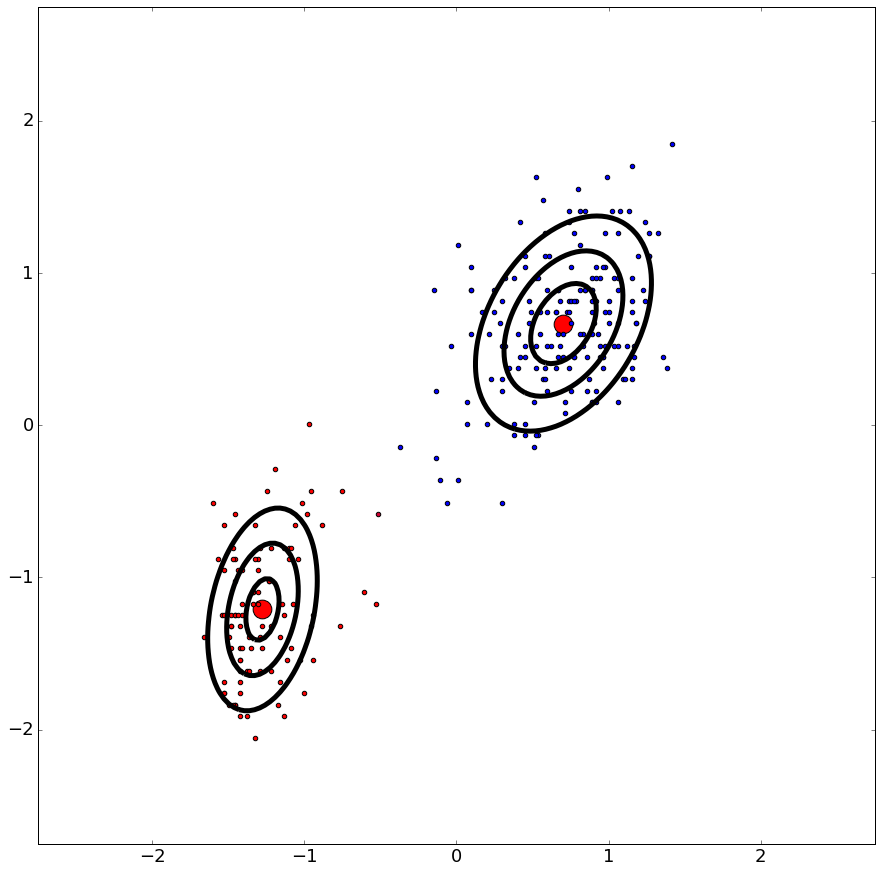

In [60]:
# reference : http://aidiary.hatenablog.com/entry/20100521/1274445325

import matplotlib.mlab as mlab
np.random.seed(100)

def gaussian(x, mean, cov):
    """多変量ガウス関数"""
    temp1 = 1 / ((2 * np.pi) ** (x.size/2.0))
    temp2 = 1 / (np.linalg.det(cov) ** 0.5)
    temp3 = - 0.5 * np.dot(np.dot(x - mean, np.linalg.inv(cov)), x - mean)
    return temp1 * temp2 * np.exp(temp3)

def likelihood(X, mean, cov, pi):
    """対数尤度関数"""
    sum = 0.0
    for n in range(len(X)):
        temp = 0.0
        for k in range(K):
            temp += pi[k] * gaussian(X[n], mean[k], cov[k])
        sum += np.log(temp)
    return sum

N = len(X)    # データ数

# 訓練データから混合ガウス分布のパラメータをEMアルゴリズムで推定する

# 平均、分散、混合係数を初期化
mean = np.random.rand(K, np.shape(X)[1])
cov = np.zeros((K, np.shape(X)[1], np.shape(X)[1]))
for k in range(K):
    cov[k] = np.eye(np.shape(X)[1])
    pi = np.random.rand(K)
pi /= sum(pi)  # 正規化

# 負担率の空配列を用意
gamma = np.zeros((N, K))

# 対数尤度の初期値を計算
like = likelihood(X, mean, cov, pi)

while True:
    # E-step : 現在のパラメータを使って、負担率を計算
    for n in range(N):
        # 分母はkによらないので最初に1回だけ計算
        denominator = sum([pi[k] * gaussian(X[n], mean[k], cov[k]) for k in range(K)])
        # 各kについて負担率を計算
        for k in range(K):
            gamma[n][k] = pi[k] * gaussian(X[n], mean[k], cov[k]) / denominator

    # M-step : 現在の負担率を使って、パラメータを再計算
    for k in range(K):
        # Nkを計算する
        Nk = sum(gamma[:, k])

        # 平均を再計算
        mean[k] = sum([gamma[n][k] * X[n] for n in range(N)]) / Nk

        # 共分散を再計算
        cov[k] = np.array([[0.0,0.0], [0.0,0.0]])
        for n in range(N):
            temp = X[n] - mean[k]
            cov[k] += gamma[n][k] * np.matrix(temp).transpose() * np.matrix(temp)
        cov[k] /= Nk

        # 混合係数を再計算
        pi[k] = Nk / N

    # 収束判定
    new_like = likelihood(X, mean, cov, pi)
    diff = new_like - like
    if diff < 0.01:
        break
    else:
        like = new_like

# ガウス分布の平均を描画
for k in range(K):
    plt.scatter(mean[k, 0], mean[k, 1], s=350, c='r', marker='o')

# 等高線を描画
xlist = np.linspace(-2.5, 2.5, 150)
ylist = np.linspace(-2.5, 2.5, 150)
x, y = np.meshgrid(xlist, ylist)
for k in range(K):
    z = mlab.bivariate_normal(x, y, np.sqrt(cov[k,0,0]), np.sqrt(cov[k,1,1]), mean[k,0], mean[k,1], cov[k,0,1])
    cs = plt.contour(x, y, z, 3, colors='k', linewidths=5)

# 訓練データを描画
red = np.array([1, 0, 0])
blue = np.array([0, 0, 1])
for n in range(N):
    color = gamma[n, 0] * red + gamma[n, 1] * blue
    plt.scatter(X[n, 0], X[n, 1], c=color)

plt.show()